In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np
from models import dataset_ops
from models import vectorization_ops
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)  # show all columns
GPUs = tf.config.list_physical_devices('GPU')
if GPUs is None or len(GPUs) == 0:
    print("WARNING: No GPU, all there is is:")
    for device in tf.config.list_physical_devices():
        print(f'- {device}')
else:
    for gpu in GPUs:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Initialized", gpu)

In [2]:
data_train, data_validation, data = dataset_ops.load_data(split_ratio=0.3, random_state=42)
data.groupby('type').aggregate('count'), data_train.groupby('type').aggregate('count'), data_validation.groupby('type').aggregate('count'),

(         url
 type        
 0     380128
 1     133956,
          url
 type        
 0     266089
 1      93769,
          url
 type        
 0     114039
 1      40187)

In [3]:
char_vectorizer = vectorization_ops.create_char_vectorizer(data_train['url'])
LC = len(char_vectorizer.word_counts)
print('Char vocab size:', LC)

Char vocab size: 157


In [4]:
dataset_train = dataset_ops.create_dataset_generator(None, char_vectorizer, data_train)\
    .shuffle(10000)\
    .prefetch(10000) #.batch(15*1024)
dataset_validation = dataset_ops.create_dataset_generator(None, char_vectorizer, data_validation)\
    .shuffle(10000)\
    .prefetch(10000) #.batch(15*1024)

print('Train:', dataset_train.element_spec, '\nValid:', dataset_validation.element_spec)

Train: ({'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None)) 
Valid: ({'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char (InputLayer)               [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 16)      2544        char[0][0]                       
__________________________________________________________________________________________________
char_conv_3 (Conv1D)            (None, 200, 32)      1568        embedding[0][0]                  
__________________________________________________________________________________________________
char_conv_5 (Conv1D)            (None, 200, 32)      2592        embedding[0][0]                  
______________________________________________________________________________________________

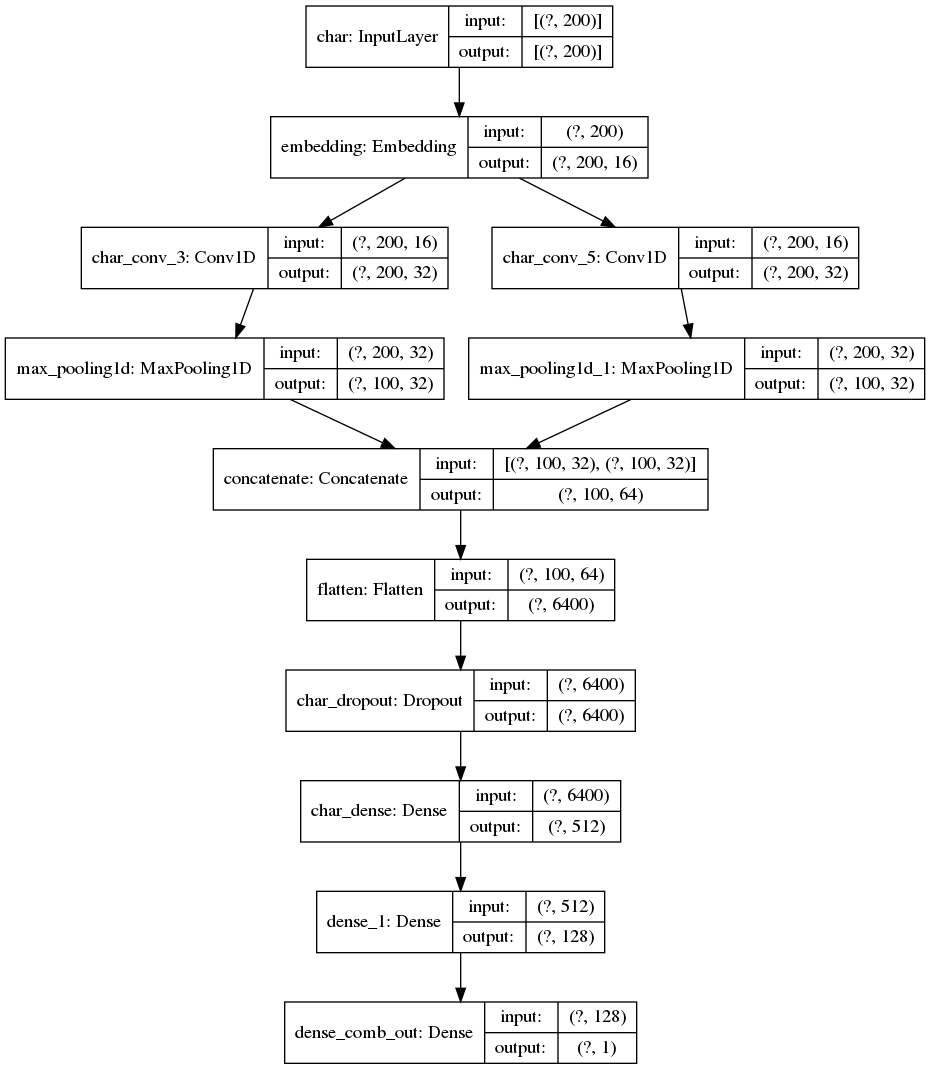

In [5]:
def create_conv_subnet(input_layer, conv_kernel_sizes, prefix=''):
    convolutions = list()
    for kernel_size in conv_kernel_sizes:
        x = k.layers.Conv1D(
            filters=32,
            kernel_size=kernel_size,
            padding='same',
            activation='relu',
            name=f'{prefix}_conv_{kernel_size}'
        )(input_layer)
        x = k.layers.MaxPool1D()(x)
        convolutions.append(x)

    x = k.layers.concatenate(convolutions, axis=2)
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'{prefix}_dropout')(x)
    x = k.layers.Dense(512, name=f'{prefix}_dense', activation='relu')(x)
    return x

def create_url_net(input_length, emb_dim, conv_kernel_sizes):
    char_input = k.layers.Input(shape=[input_length], name='char')

    x = create_conv_subnet(
        k.layers.Embedding(2+LC, emb_dim, mask_zero=True)(char_input),
        conv_kernel_sizes,
        'char'
    )

    x = k.layers.Dense(128, activation='relu', name='dense_1')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_out')(x)

    model = k.models.Model(inputs=[char_input], outputs=[x])
    return model

model = create_url_net(
    input_length=200,
    emb_dim=16,
    conv_kernel_sizes=[3,5]
)
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']#, k.metrics.Precision(), k.metrics.Recall()]
)
#     loss='binary_crossentropy',
model.summary()
k.utils.plot_model(model, show_shapes=True)

In [ ]:
bs=256*8

model.fit(
    dataset_train.batch(bs),
    epochs=100,
    validation_data=dataset_validation.batch(bs),
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        k.callbacks.ModelCheckpoint('./checkpoints', verbose=0)
    ],
)

In [ ]:
model.save('full_convolution')

In [6]:
model = k.models.load_model('full_convolution')

In [9]:
X_validation, y_validation = np.array([*dataset_validation.as_numpy_iterator()]).T
X_validation = np.array([item['char'] for item in X_validation])

In [11]:
X_validation2 = tf.data.Dataset.from_tensor_slices(((X_validation, X_validation),)).batch(bs)
y_validation = y_validation.astype('int32')

y_hat = model.predict(X_validation2).ravel()

In [12]:
fpr, tpr, thresholds = roc_curve(y_validation, y_hat)
auc_ = auc(fpr, tpr)
best_threshold = thresholds[np.argmax(-fpr + tpr)]

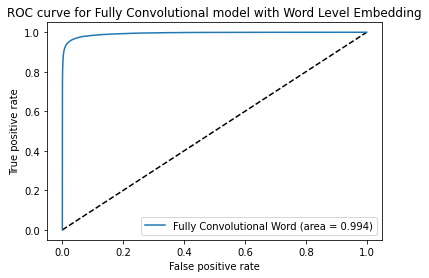

In [13]:
model_name = "Fully Convolutional Word"
model_full_name = "Fully Convolutional model with Word Level Embedding"

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'{model_name} (area = {auc_:.3f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for {model_full_name}')
plt.legend(loc='best')
plt.savefig(f'../plots/{model_name.replace(" ", "_").lower()}_roc.pdf')
plt.show()

In [14]:
y_hat_01 = np.zeros_like(y_hat)
y_hat_01[y_hat >= best_threshold] = 1

np.unique(y_hat_01)

array([0., 1.], dtype=float32)

In [15]:
precision_recall_fscore_support(y_validation, y_hat_01, beta=1, average='binary')

(0.9244006047951616, 0.9584442730236146, 0.9411146675788599, None)

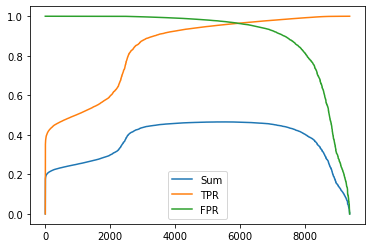

In [16]:
plt.plot((-fpr + tpr) / 2, label='Sum')
plt.plot(tpr, label='TPR')
plt.plot(1-fpr, label='FPR')
plt.legend()

In [17]:
np.save("fpr_tpr/fccl-fpr", fpr)
np.save("fpr_tpr/fccl-tpr", tpr)
